# Analysis

In [90]:
from dataclasses import dataclass

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import pickle
import os

In [63]:
# input data folders
PERFORMANCEDIR = "/Users/manuel/Desktop/TF-PWM-SVM-comparison/benchmark/performance"
# test negative data types
BGTEST = ["shuffle", "dnase-1", "dnase"]
DBDDICT = "dbd.pickle"

## Compare performance training models using different numbers of training sequences

In [35]:
def compute_mean(infolder, size, tool, metric):
    fname = os.path.join(infolder, f"summary_table_size_{size}_{tool}.tsv")
    table = pd.read_csv(fname, sep="\t")
    return np.mean(table[metric]).round(2)

def plot(data, labels, group_labels, metric, bg):
    num_groups = len(group_labels)
    num_bars = len(data)
    x = np.arange(num_groups)  # The label locations
    width = 0.1 # The width of the bars
    colors = ["#f7b32b", "#d9940a", "#b57900", "#399be8", "#1679c6", "#005ca3", "#ec8746", "#d96b24", "#bf4e05"]  # meme, streme, ls-gkm
    f, ax = plt.subplots(figsize=(40, 10))
    for i, (values, label) in enumerate(zip(data, labels)):
        bars = ax.bar(x + i * width, values, width, label=label, color=colors[i])
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom', fontsize=10)
    ax.set_xlabel("Training Dataset size", size=14)
    ax.set_ylabel(metric, size=14)
    ax.set_title(f"{metric} - Training on {bg}", size=18)
    ax.set_xticks(x + width * (num_bars / 2 - 0.5))
    ax.set_xticklabels(group_labels, size=12)
    ax.legend()
    plt.show()


def barplot(infolder, metric, bg):
    sizes = [500, 1000, 2000, 5000, 10000, "full"]
    tools = ["MEME (PWM)", "STREME (PWM)", "LS-GKM (SVM)"]
    data = [[] for _ in range(9)]
    for size in sizes:
        for i, (trainbg, testbg) in enumerate([(bg, bt) for bt in BGTEST]):
            tablesdir = os.path.join(infolder, f"{trainbg}-{testbg}")
            data[0 + i].append(compute_mean(tablesdir, size, "meme", metric))
            data[3 + i].append(compute_mean(tablesdir, size, "streme", metric))
            data[6 + i].append(compute_mean(tablesdir, size, "svm", metric))
    labels = [f"{tool} - test background: {testbg}" for tool in tools for testbg in BGTEST]
    bgtitle = "real biological background data" if bg == "dnase" else "synthetic background data"
    plot(data, labels, sizes, metric, bgtitle)


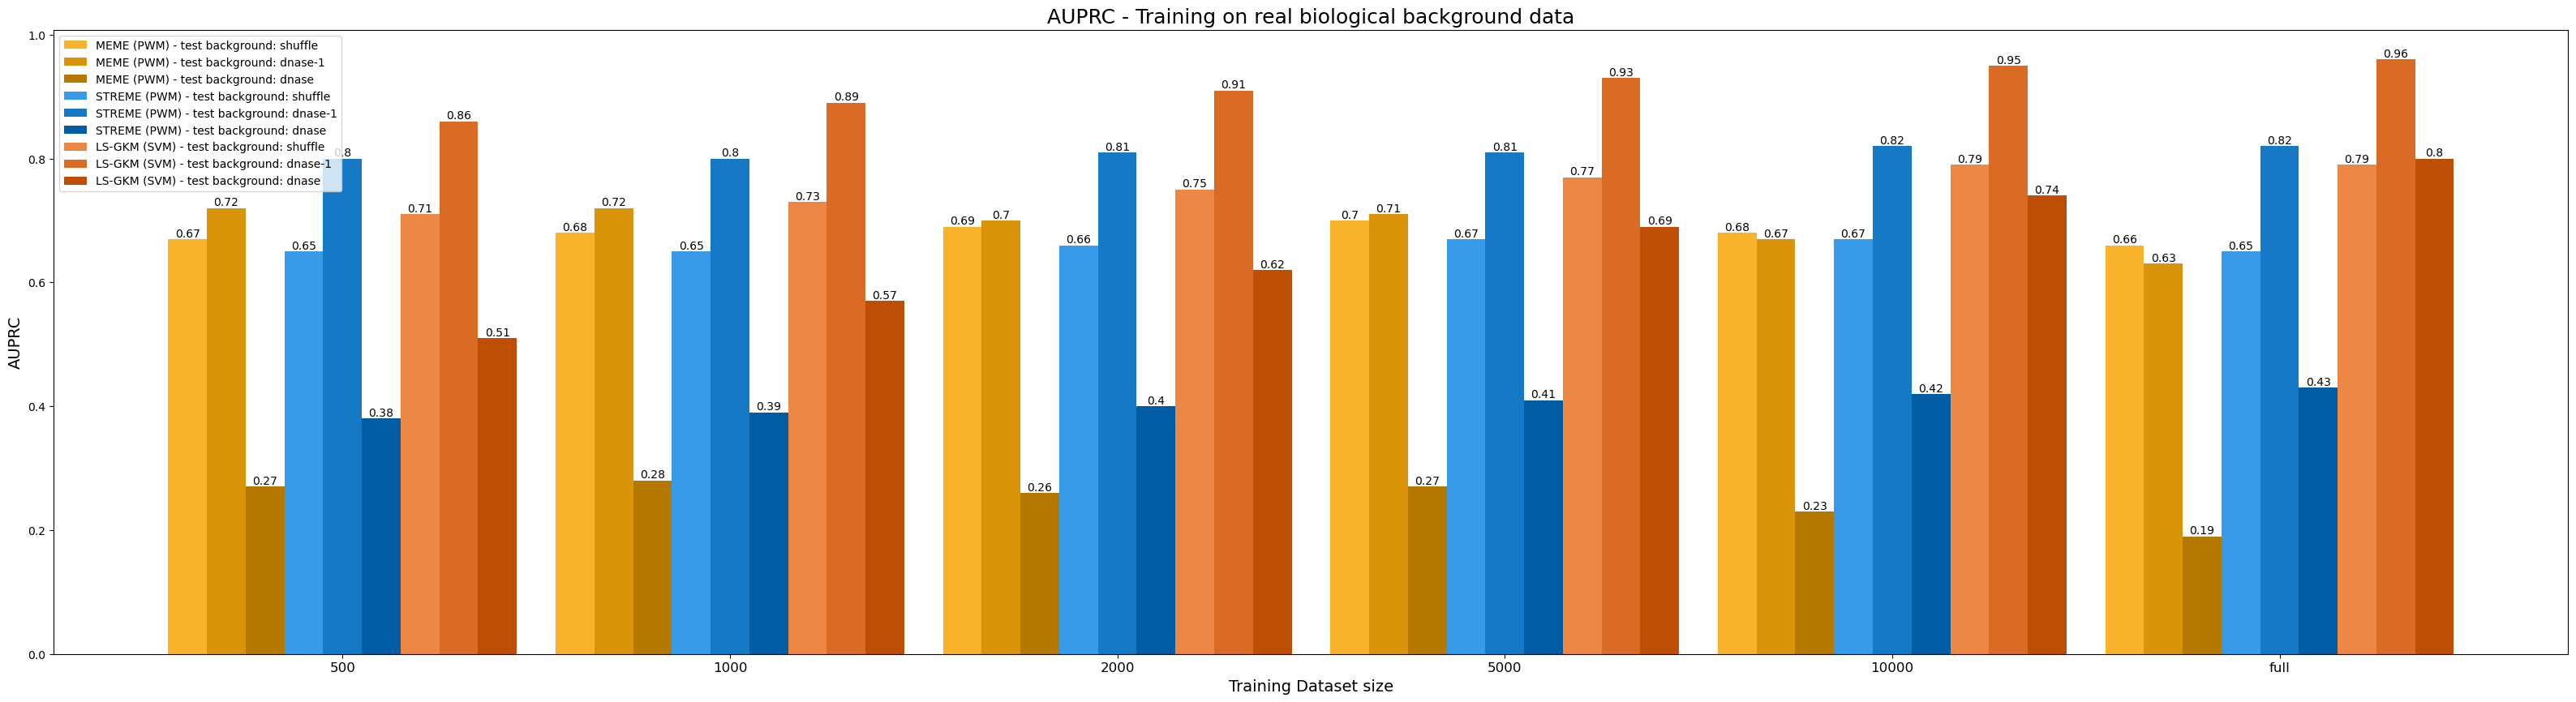

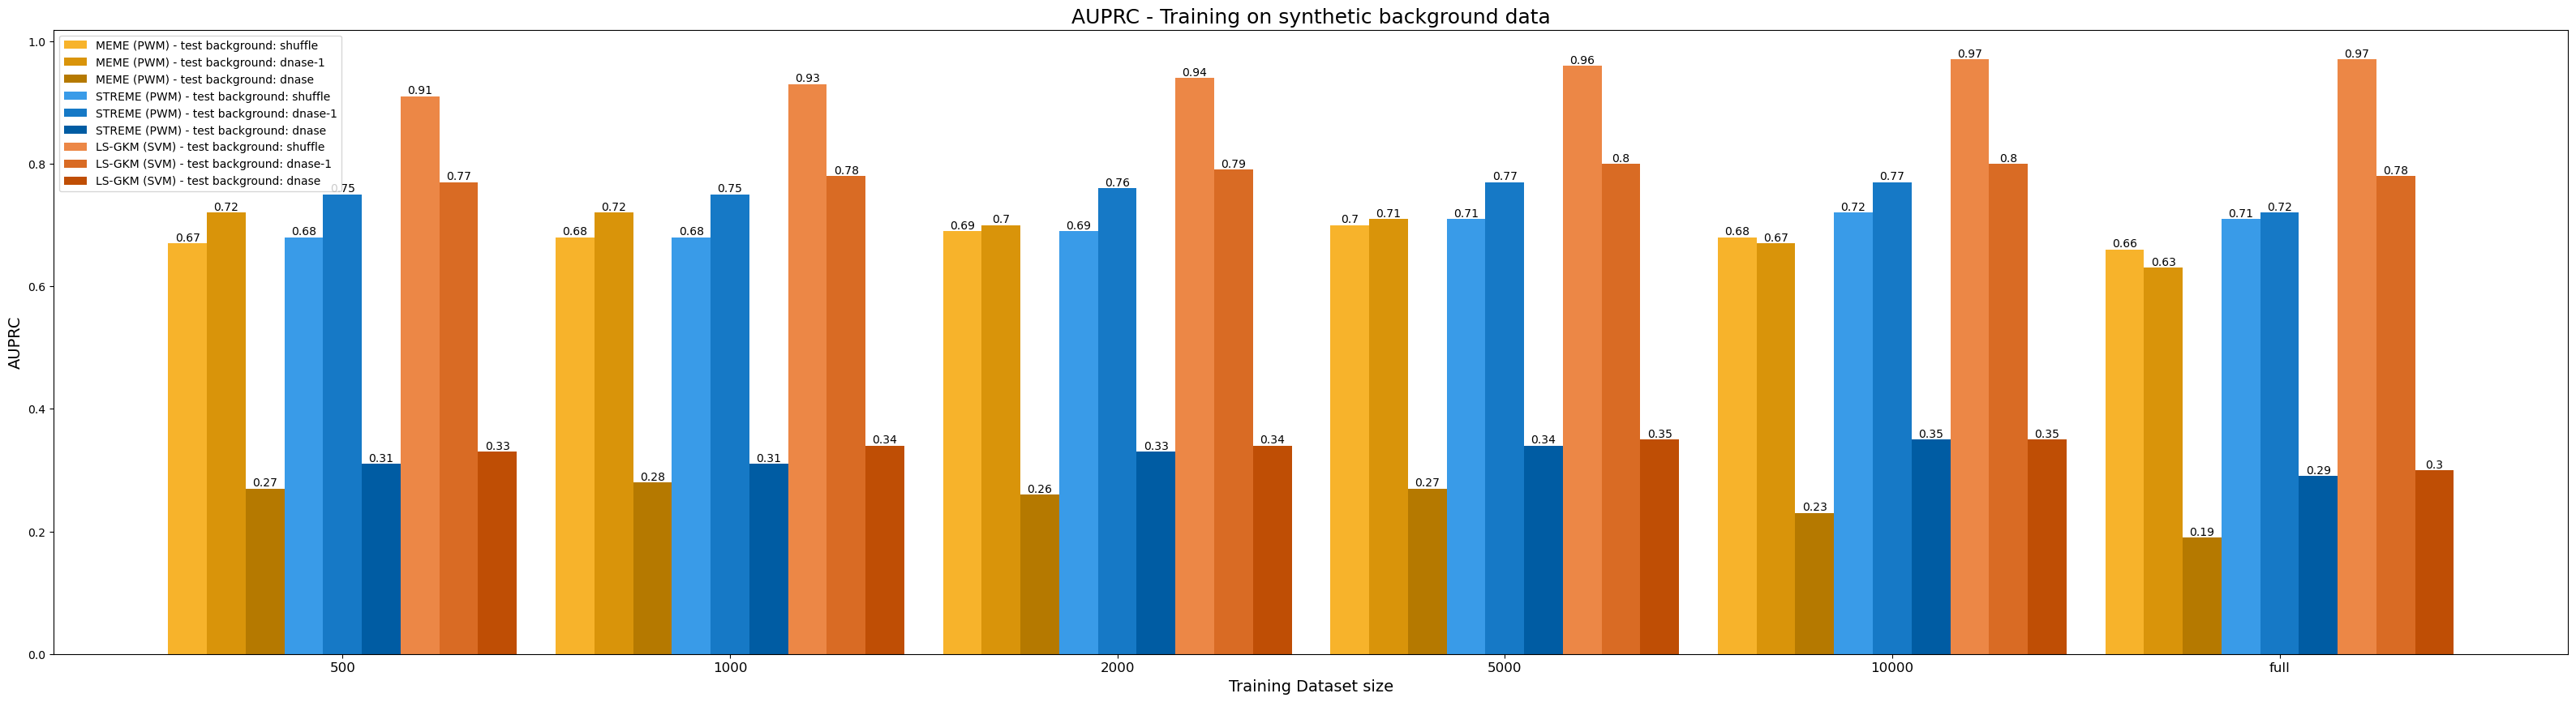

In [39]:
# AUPRC
performance_dir = os.path.join(PERFORMANCEDIR, "dataset-size-comparison")
for bg in ["dnase", "shuffle"]:
    barplot(performance_dir, "AUPRC", bg)

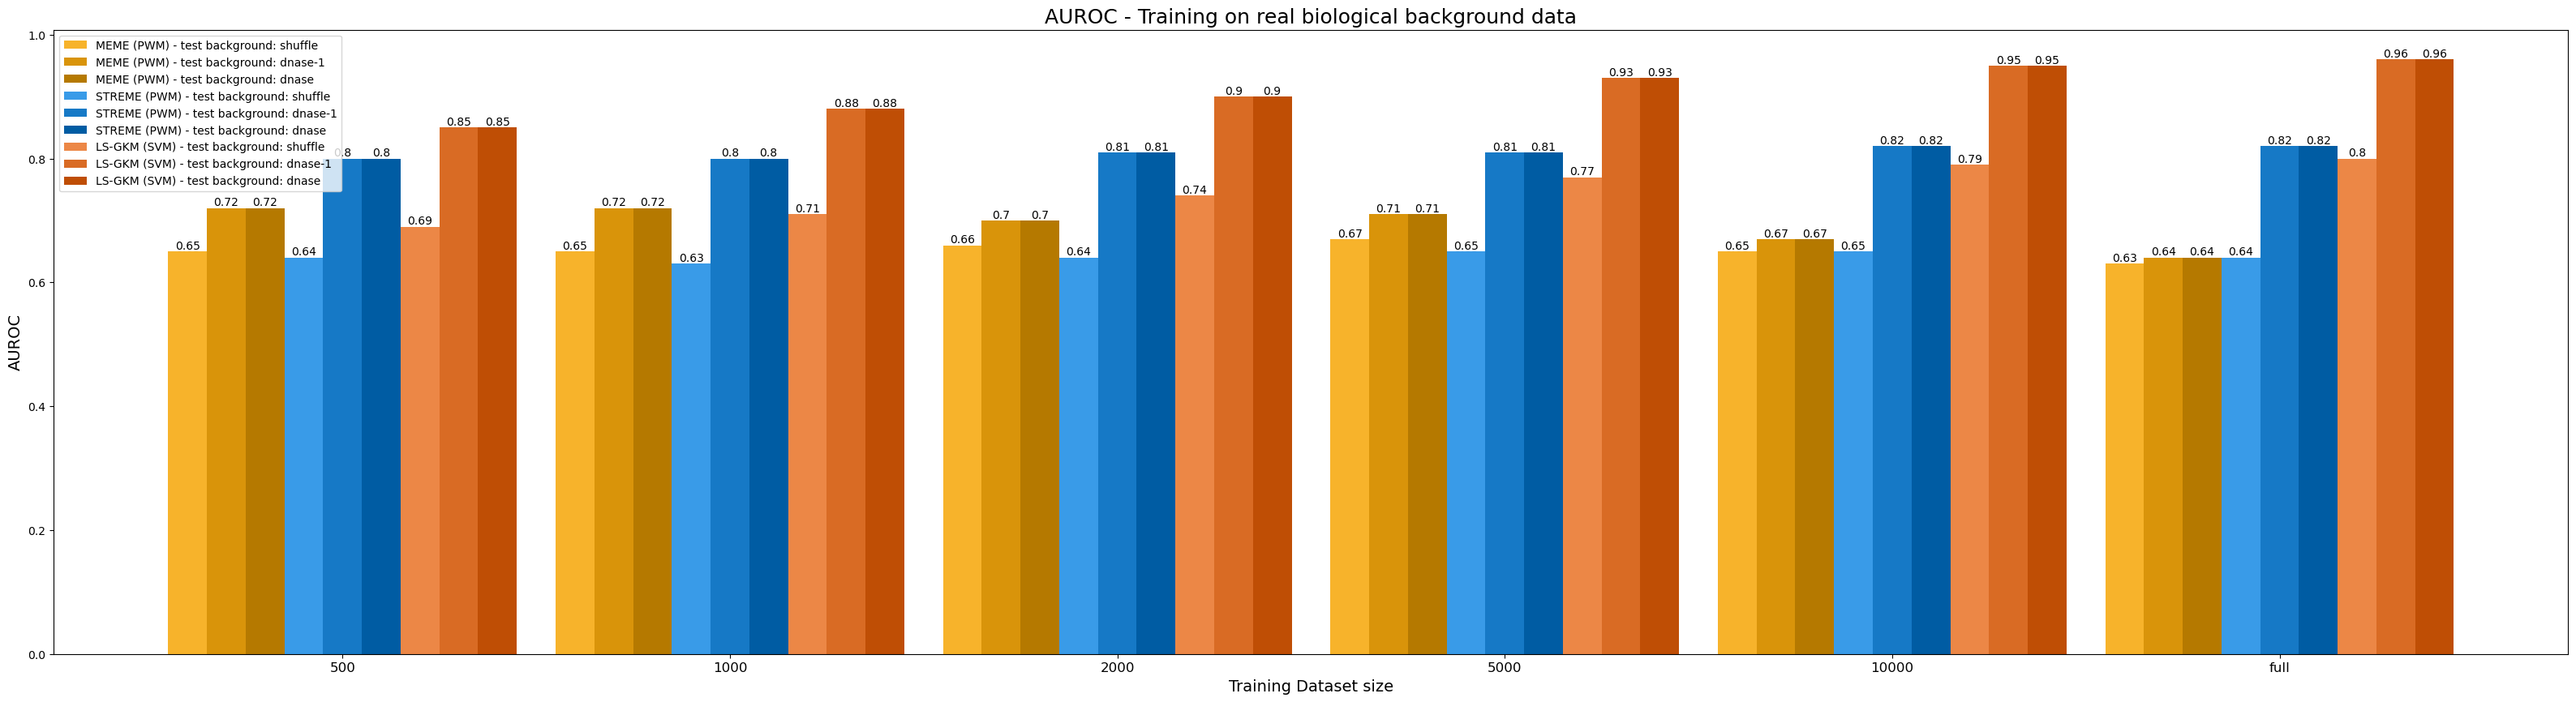

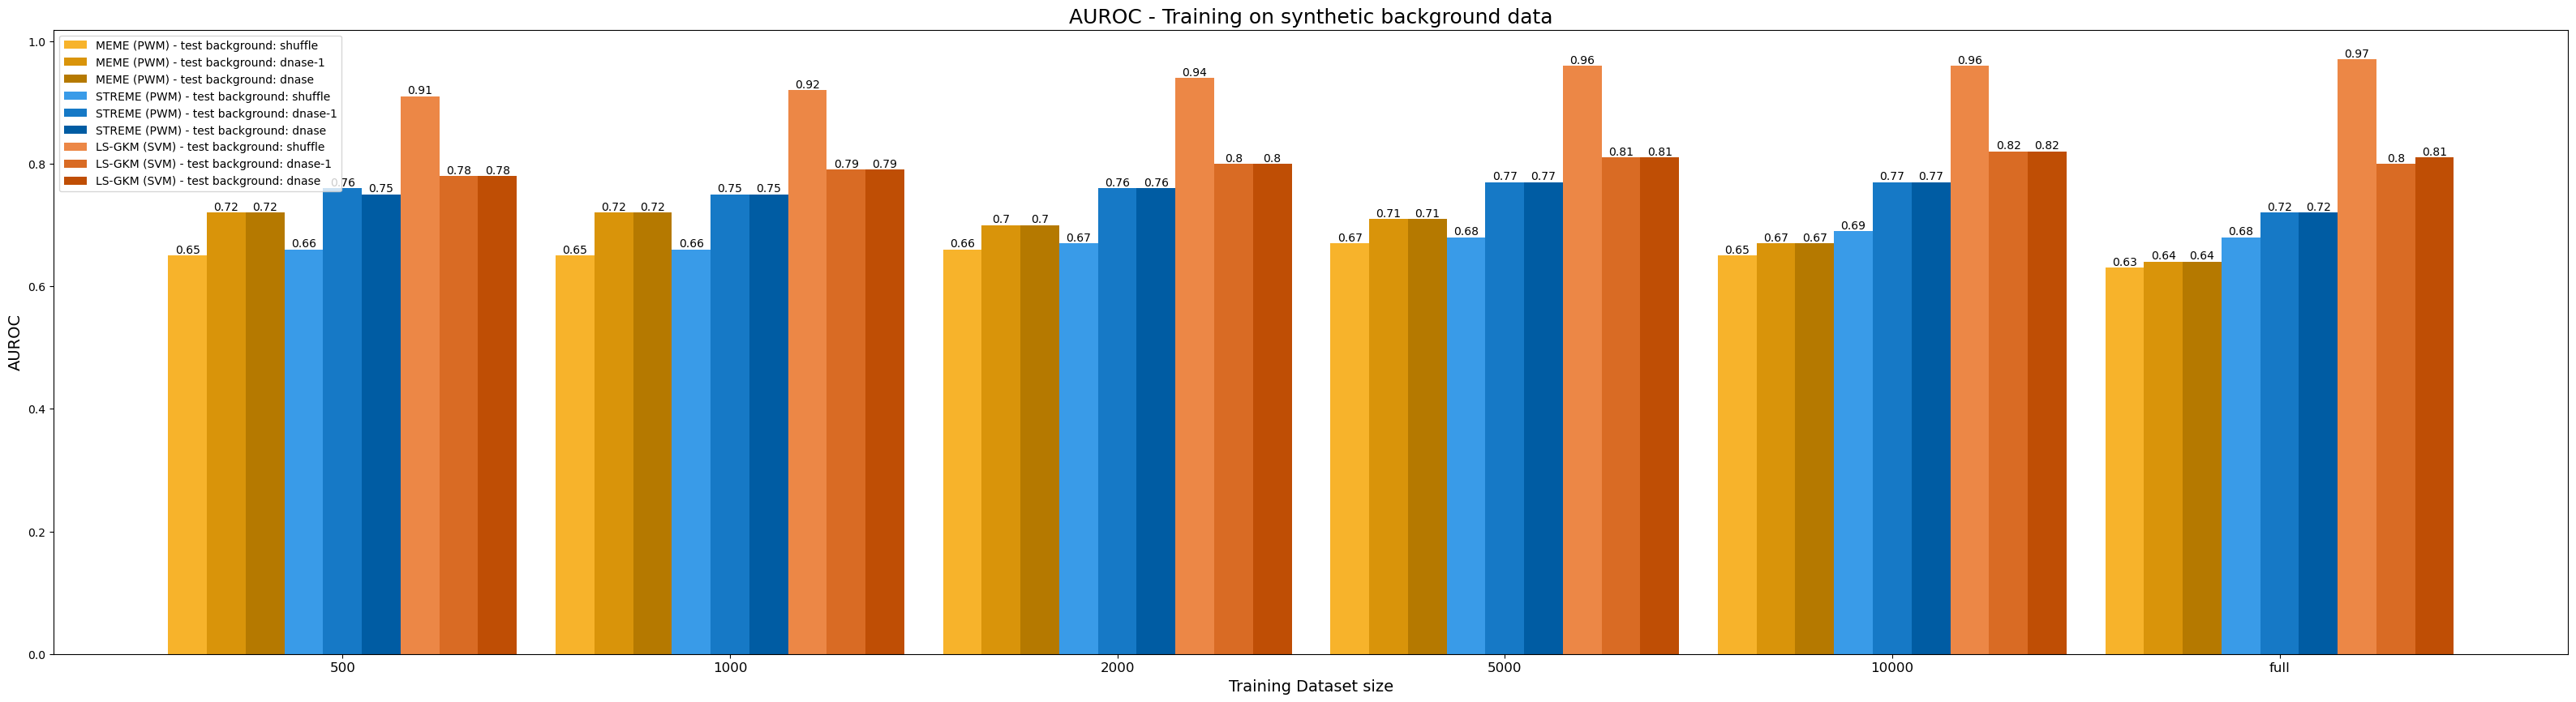

In [40]:
# AUROC
performance_dir = os.path.join(PERFORMANCEDIR, "dataset-size-comparison")
for bg in ["dnase", "shuffle"]:
    barplot(performance_dir, "AUROC", bg)

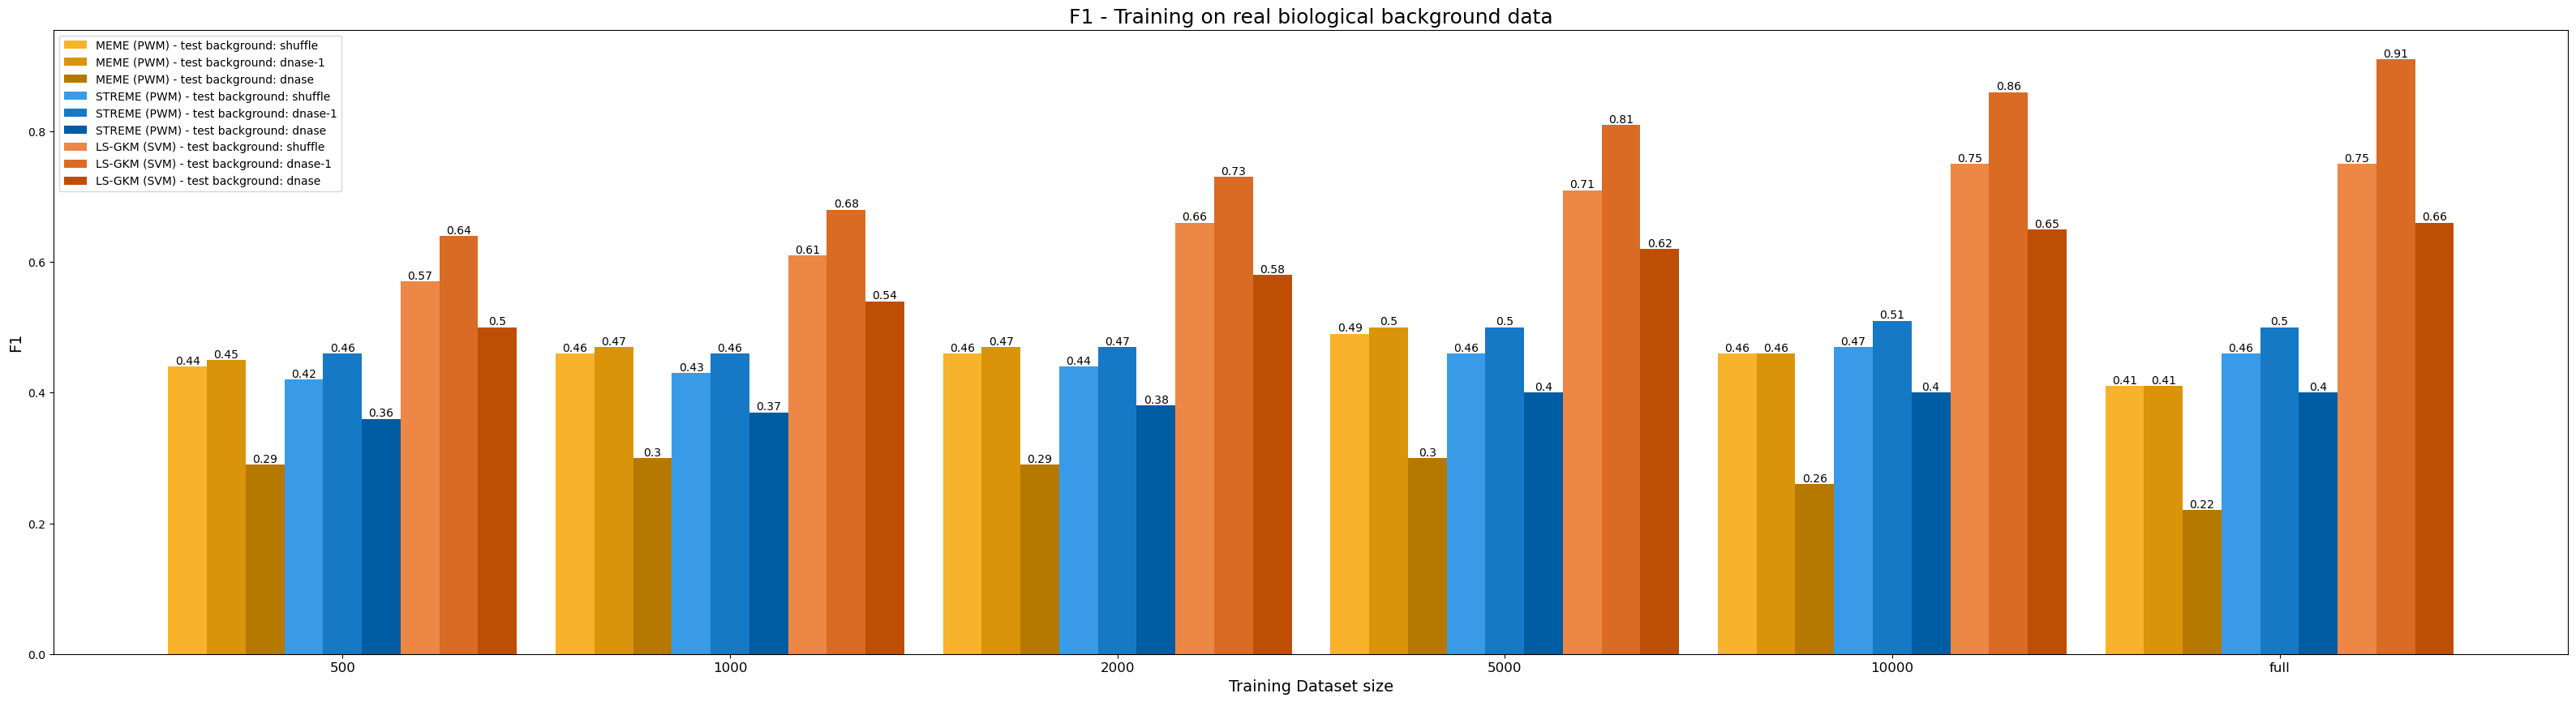

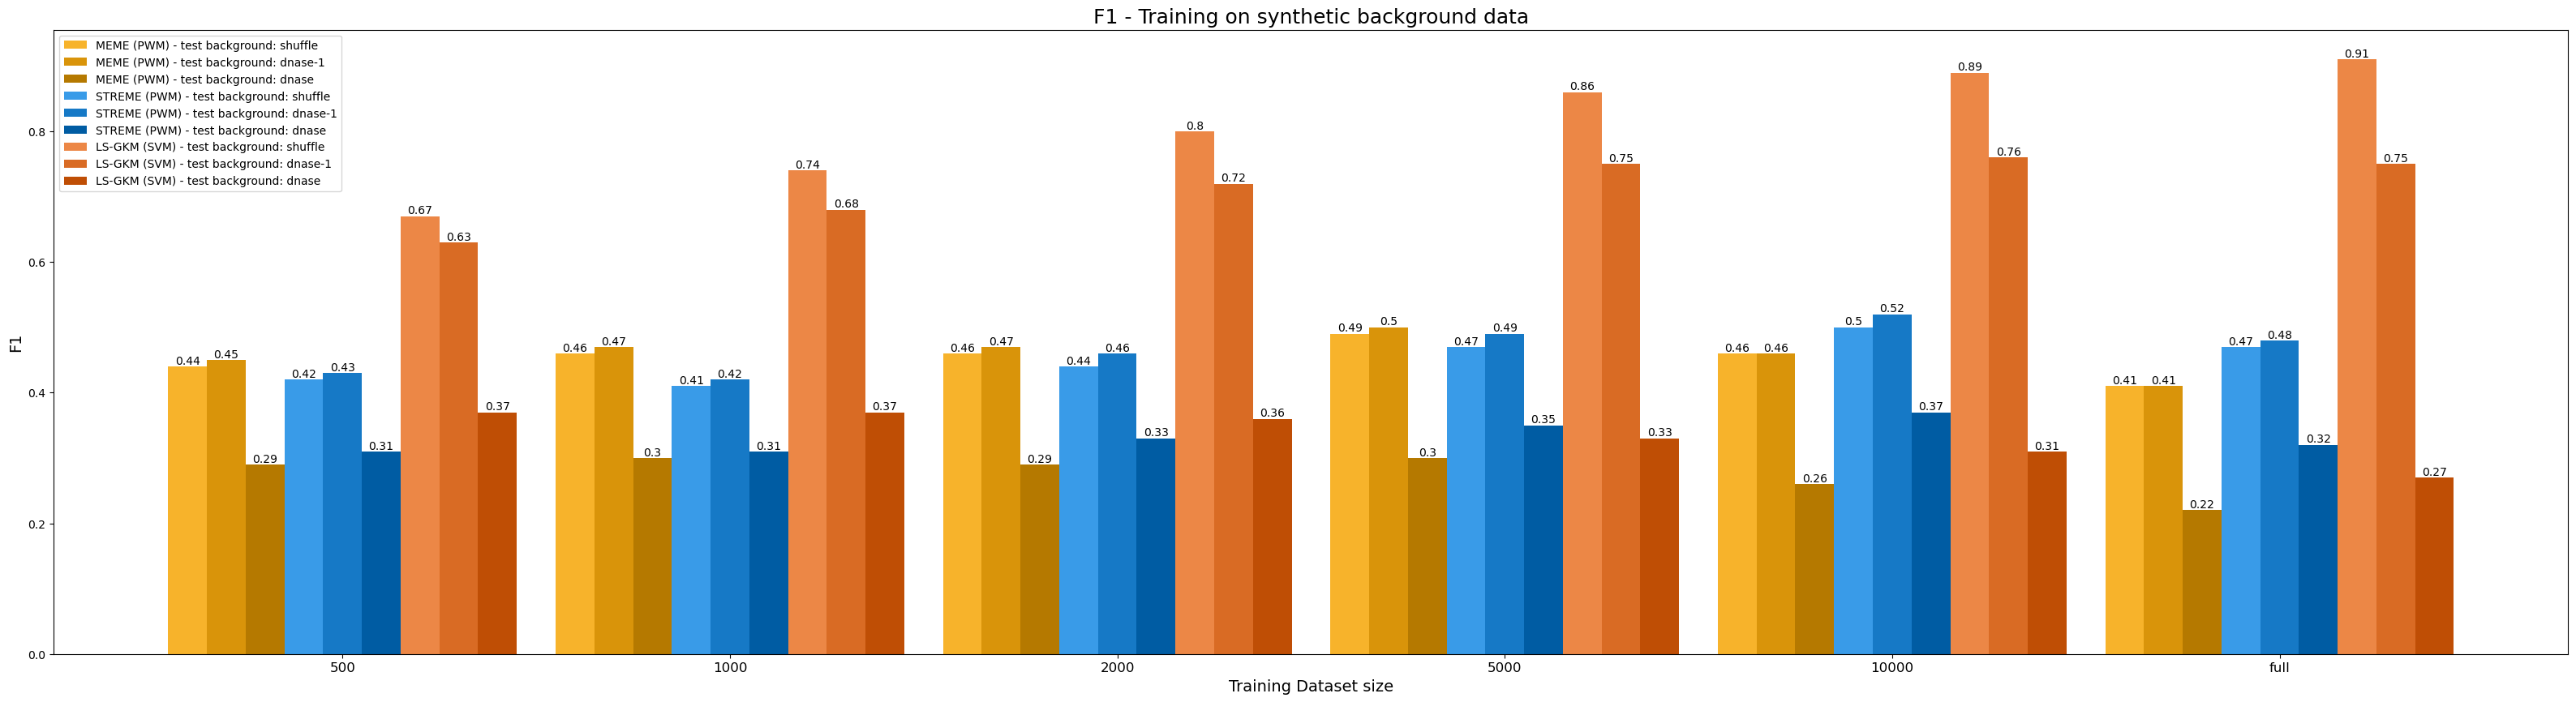

In [ ]:
# F1
performance_dir = os.path.join(PERFORMANCEDIR, "dataset-size-comparison")
for bg in ["dnase", "shuffle"]:
    barplot(performance_dir, "F1", bg)

In [98]:
def assign_dbd(experiment, dbds):
    return dbds[experiment]

def process_table(table, dbds):
    table["DBD"] = table.apply(lambda x: assign_dbd(x.loc["EXPERIMENT"], dbds), axis=1)
    return table

def compute_mean(infolder, size, dbds, dbd, tool, metric):
    fname = os.path.join(infolder, f"summary_table_size_{size}_{tool}.tsv")
    table = pd.read_csv(fname, sep="\t")
    table = process_table(table, dbds)
    table = table[table["DBD"] == dbd]
    return np.mean(table[metric])

def plot(data, metric):
    f, ax = plt.subplots(1, 1, figsize=(20, 10))
    sns.lineplot(data=data, x="dbd", y=metric, hue="label", ax=ax, marker="o")
    

def lineplot(infolder, metric, bg):
    sizes = [500, 1000, 2000, 5000, 10000, "full"]
    tools = ["MEME (PWM)", "STREME (PWM)", "LS-GKM (SVM)"]
    data = {"label": [], metric: [], "dbd": []}
    with open(DBDDICT, mode="rb") as f:
        dbds = pickle.load(f)
    for i, (trainbg, testbg) in enumerate([(bg, bt) for bt in ["dnase-1"]]):
        tablesdir = os.path.join(infolder, f"{trainbg}-{testbg}")
        for size in sizes:
            for i, t in enumerate(["meme", "streme", "svm"]):
                for dbd in set(dbds.values()):
                    data["label"].append(f"{tools[i]} - {size}")
                    data[metric].append(compute_mean(tablesdir, size, dbds, dbd, t, metric))
                    data["dbd"].append(dbd)
        plot(pd.DataFrame(data), metric)
    # for size in sizes:
    #     for i, (trainbg, testbg) in enumerate([(bg, bt) for bt in BGTEST]):
    #         tablesdir = os.path.join(infolder, f"{trainbg}-{testbg}")
    #         for i, t in enumerate(["meme", "streme", "svm"]):
    #             for dbd in set(dbds.values()):
    #                 data["tool"].append(f"{tools[i]} - test background: {testbg}")
    #                 data[metric].append(compute_mean(tablesdir, size, dbds, dbd, t, metric))
    #                 data["dbd"].append(dbd)
    #                 data["size"].append(size)
    # labels = [f"{tool} - test background: {testbg}" for tool in tools for testbg in BGTEST]
    # bgtitle = "real biological background data" if bg == "dnase" else "synthetic background data"
    

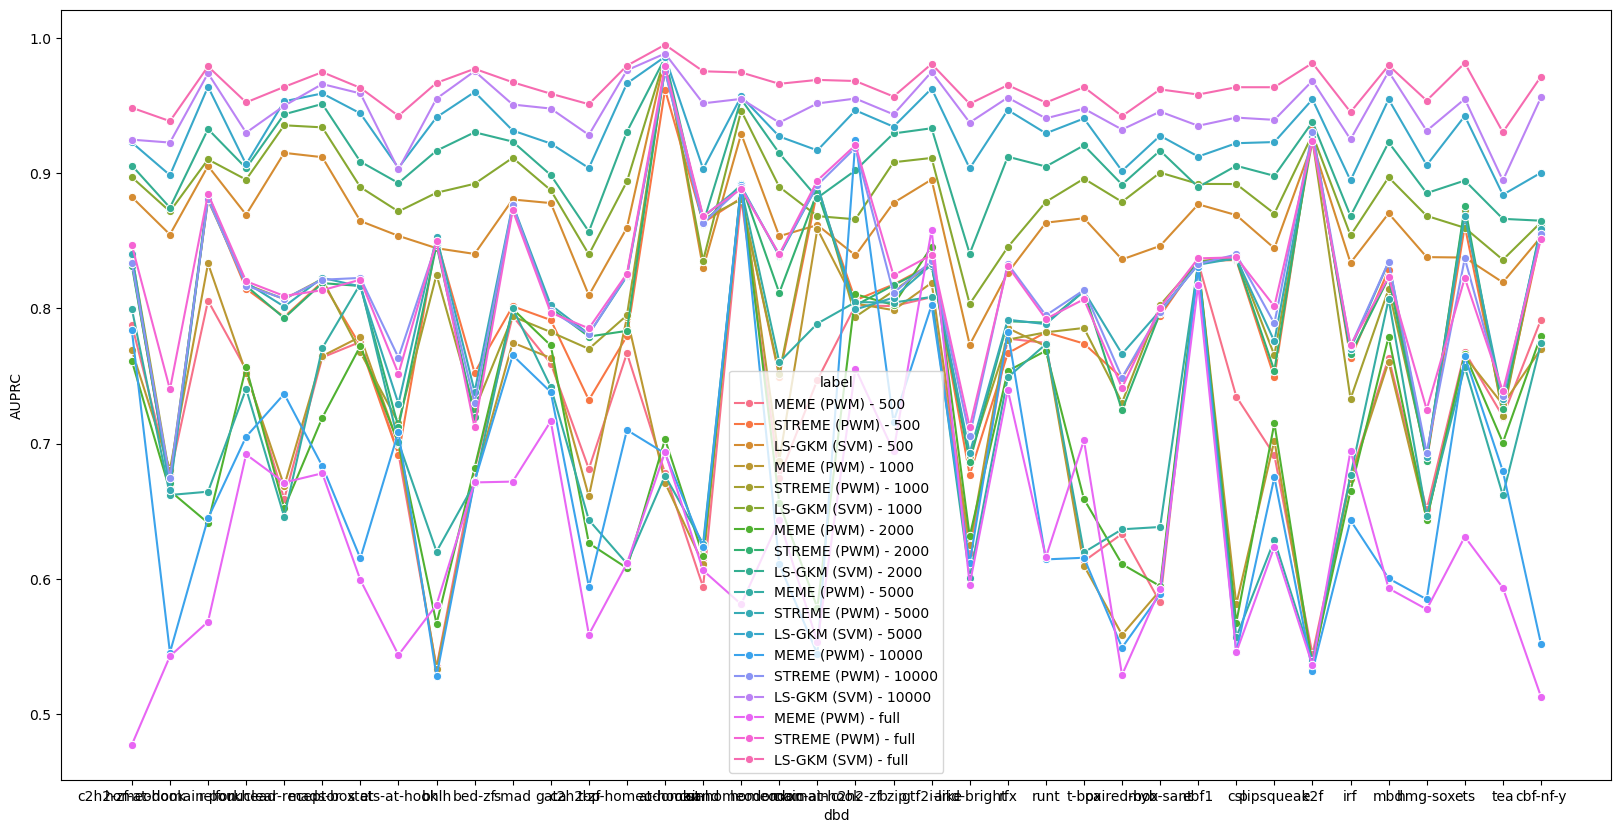

In [100]:
# F1
performance_dir = os.path.join(PERFORMANCEDIR, "dataset-size-comparison")
for bg in ["dnase"]: #, "shuffle"]:
    lineplot(performance_dir, "AUPRC", bg)

## Compare performance training models using different widths of training sequences

In [42]:
def compute_mean(infolder, width, tool, metric):
    fname = os.path.join(infolder, f"summary_table_width_{width}_{tool}.tsv")
    table = pd.read_csv(fname, sep="\t")
    return np.mean(table[metric]).round(2)

def plot(data, labels, group_labels, metric, bg):
    num_groups = len(group_labels)
    num_bars = len(data)
    x = np.arange(num_groups)  # The label locations
    width = 0.1 # The width of the bars
    colors = ["#f7b32b", "#d9940a", "#b57900", "#399be8", "#1679c6", "#005ca3", "#ec8746", "#d96b24", "#bf4e05"]  # meme, streme, ls-gkm
    f, ax = plt.subplots(figsize=(40, 10))
    for i, (values, label) in enumerate(zip(data, labels)):
        bars = ax.bar(x + i * width, values, width, label=label, color=colors[i])
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom', fontsize=10)
    ax.set_xlabel("Training Sequence width", size=14)
    ax.set_ylabel(metric, size=14)
    ax.set_title(f"{metric} - Training on {bg}", size=18)
    ax.set_xticks(x + width * (num_bars / 2 - 0.5))
    ax.set_xticklabels(group_labels, size=12)
    ax.legend()
    plt.show()


def barplot(infolder, metric, bg):
    widths = [50, 100, 150, 200, "full"]
    tools = ["MEME (PWM)", "STREME (PWM)", "LS-GKM (SVM)"]
    data = [[] for _ in range(9)]
    for width in widths:
        for i, (trainbg, testbg) in enumerate([(bg, bt) for bt in BGTEST]):
            tablesdir = os.path.join(infolder, f"{trainbg}-{testbg}")
            data[0 + i].append(compute_mean(tablesdir, width, "meme", metric))
            data[3 + i].append(compute_mean(tablesdir, width, "streme", metric))
            data[6 + i].append(compute_mean(tablesdir, width, "svm", metric))
    labels = [f"{tool} - test background: {testbg}" for tool in tools for testbg in BGTEST]
    bgtitle = "real biological background data" if bg == "dnase" else "synthetic background data"
    plot(data, labels, widths, metric, bgtitle)


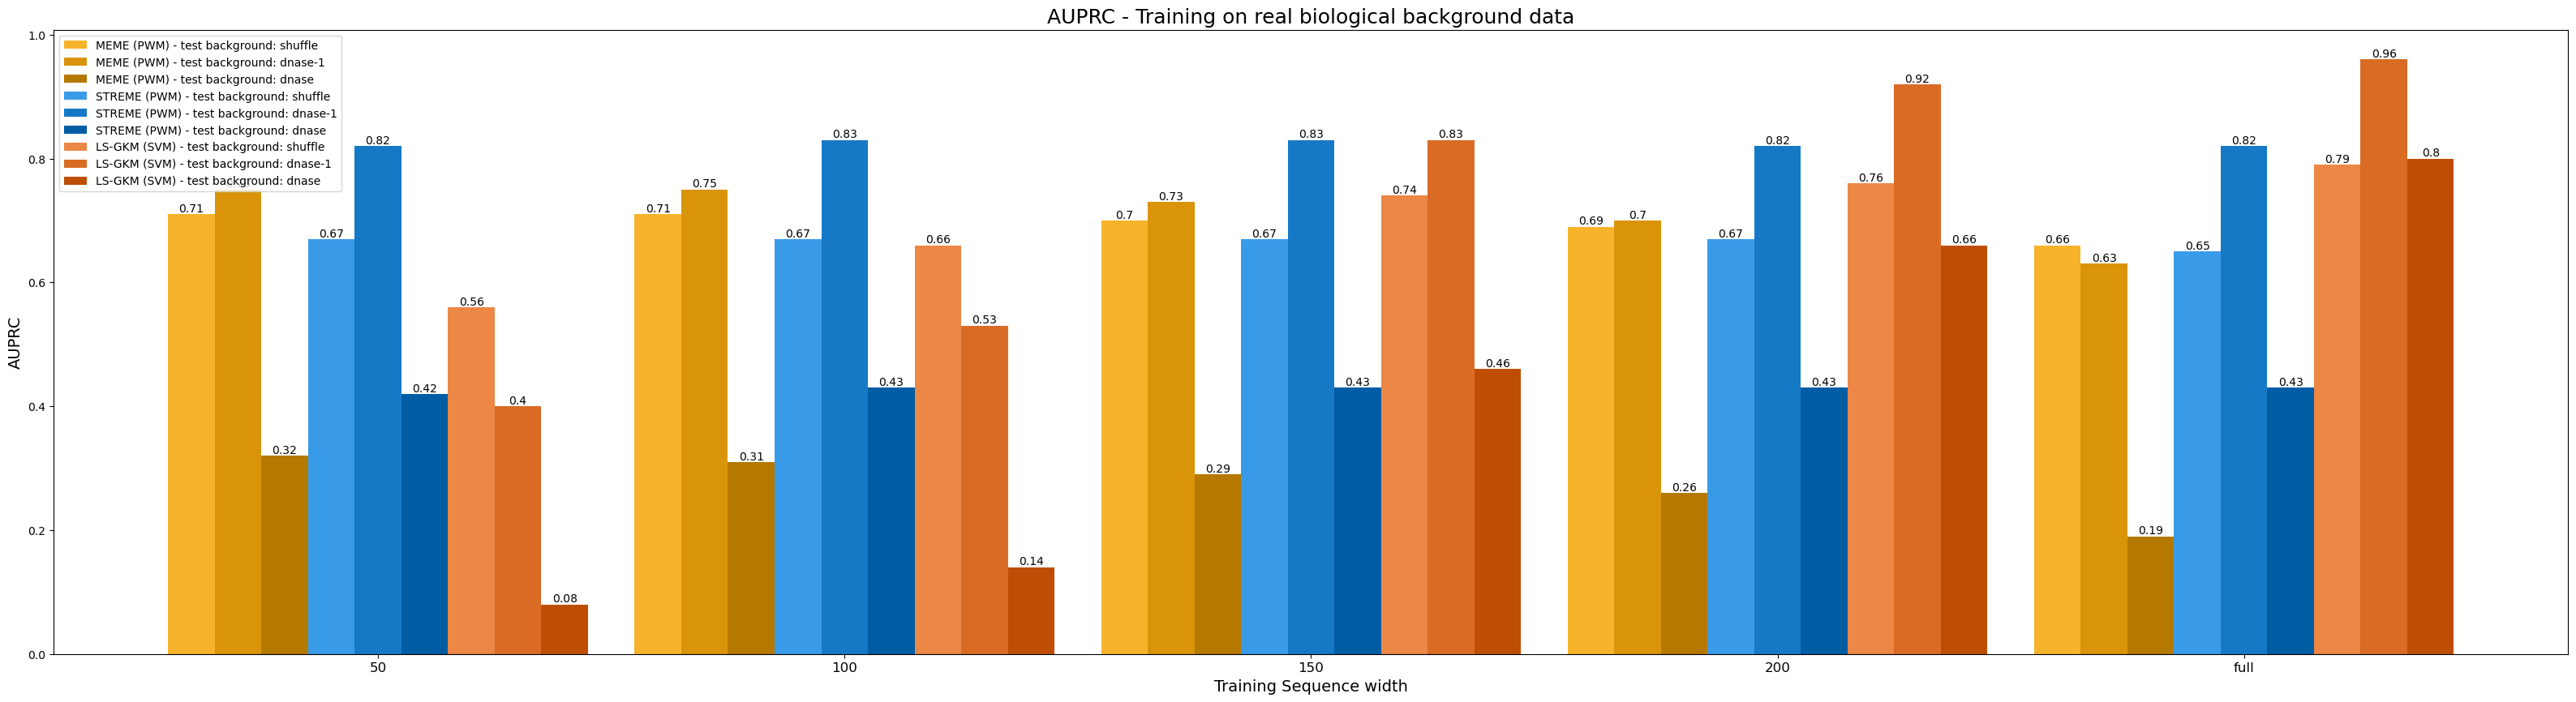

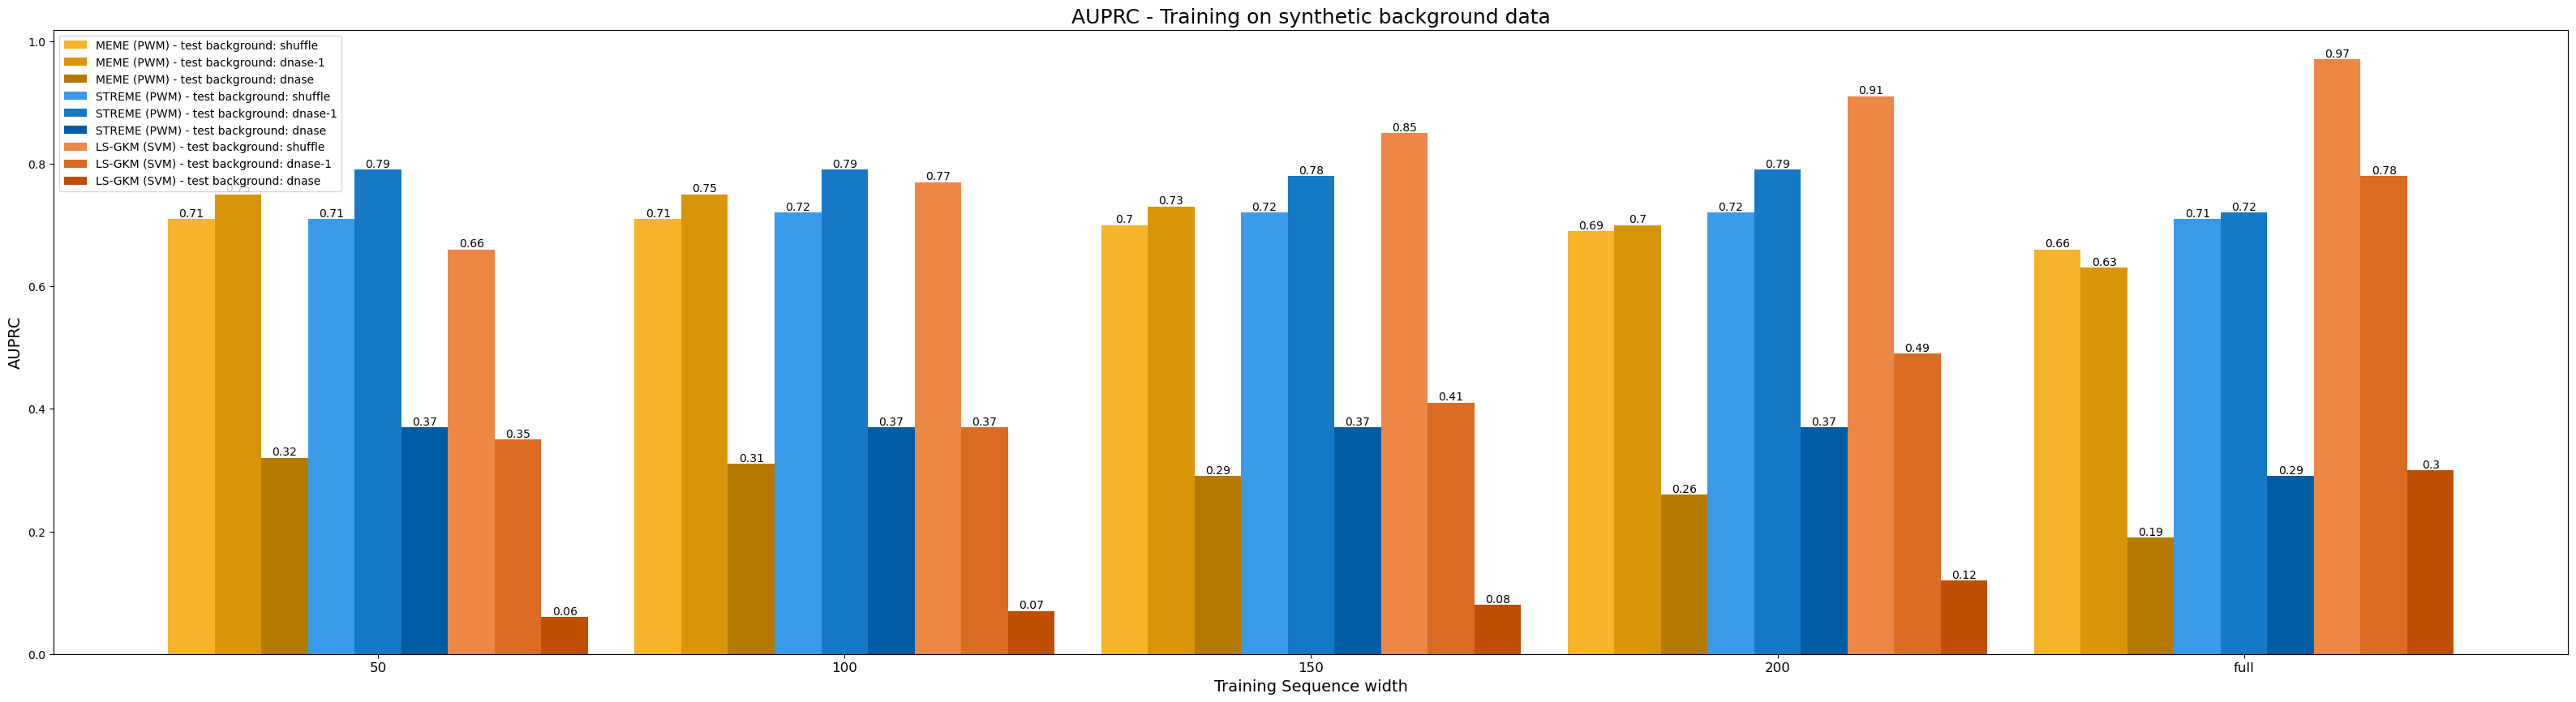

In [43]:
# AUPRC
performance_dir = os.path.join(PERFORMANCEDIR, "sequence-width-comparison")
for bg in ["dnase", "shuffle"]:
    barplot(performance_dir, "AUPRC", bg)

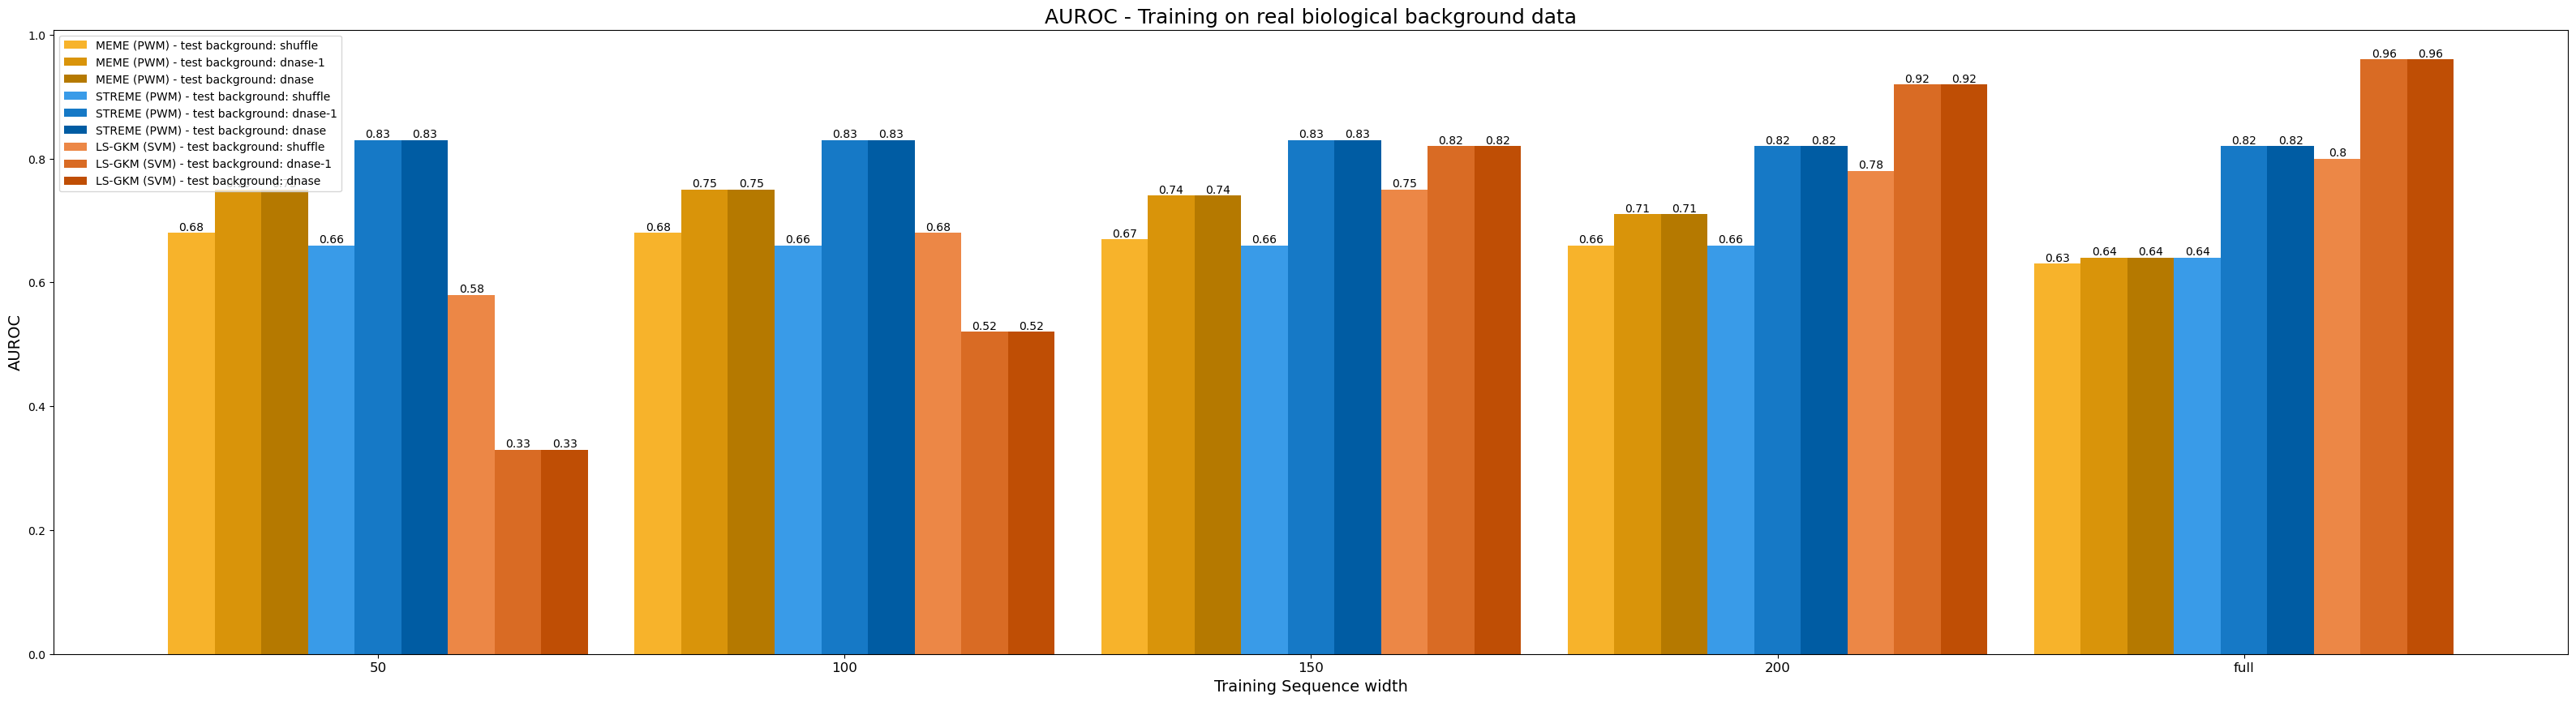

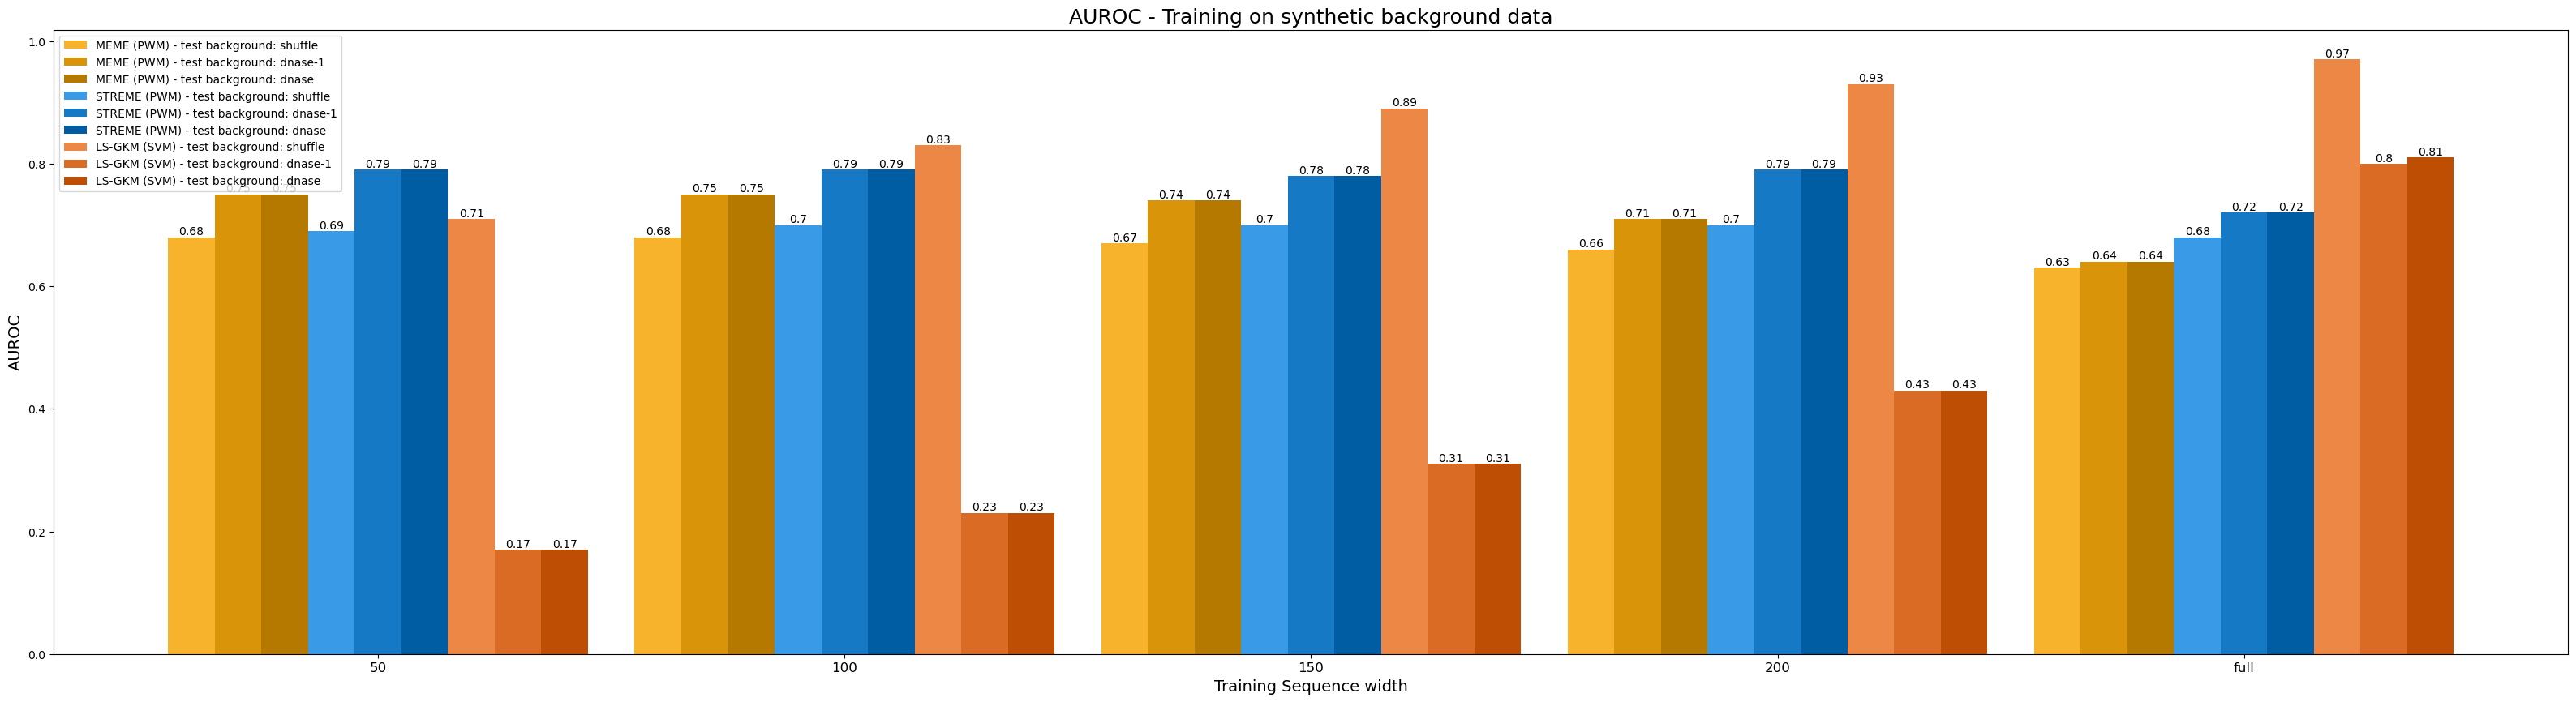

In [44]:
# AUROC
performance_dir = os.path.join(PERFORMANCEDIR, "sequence-width-comparison")
for bg in ["dnase", "shuffle"]:
    barplot(performance_dir, "AUROC", bg)

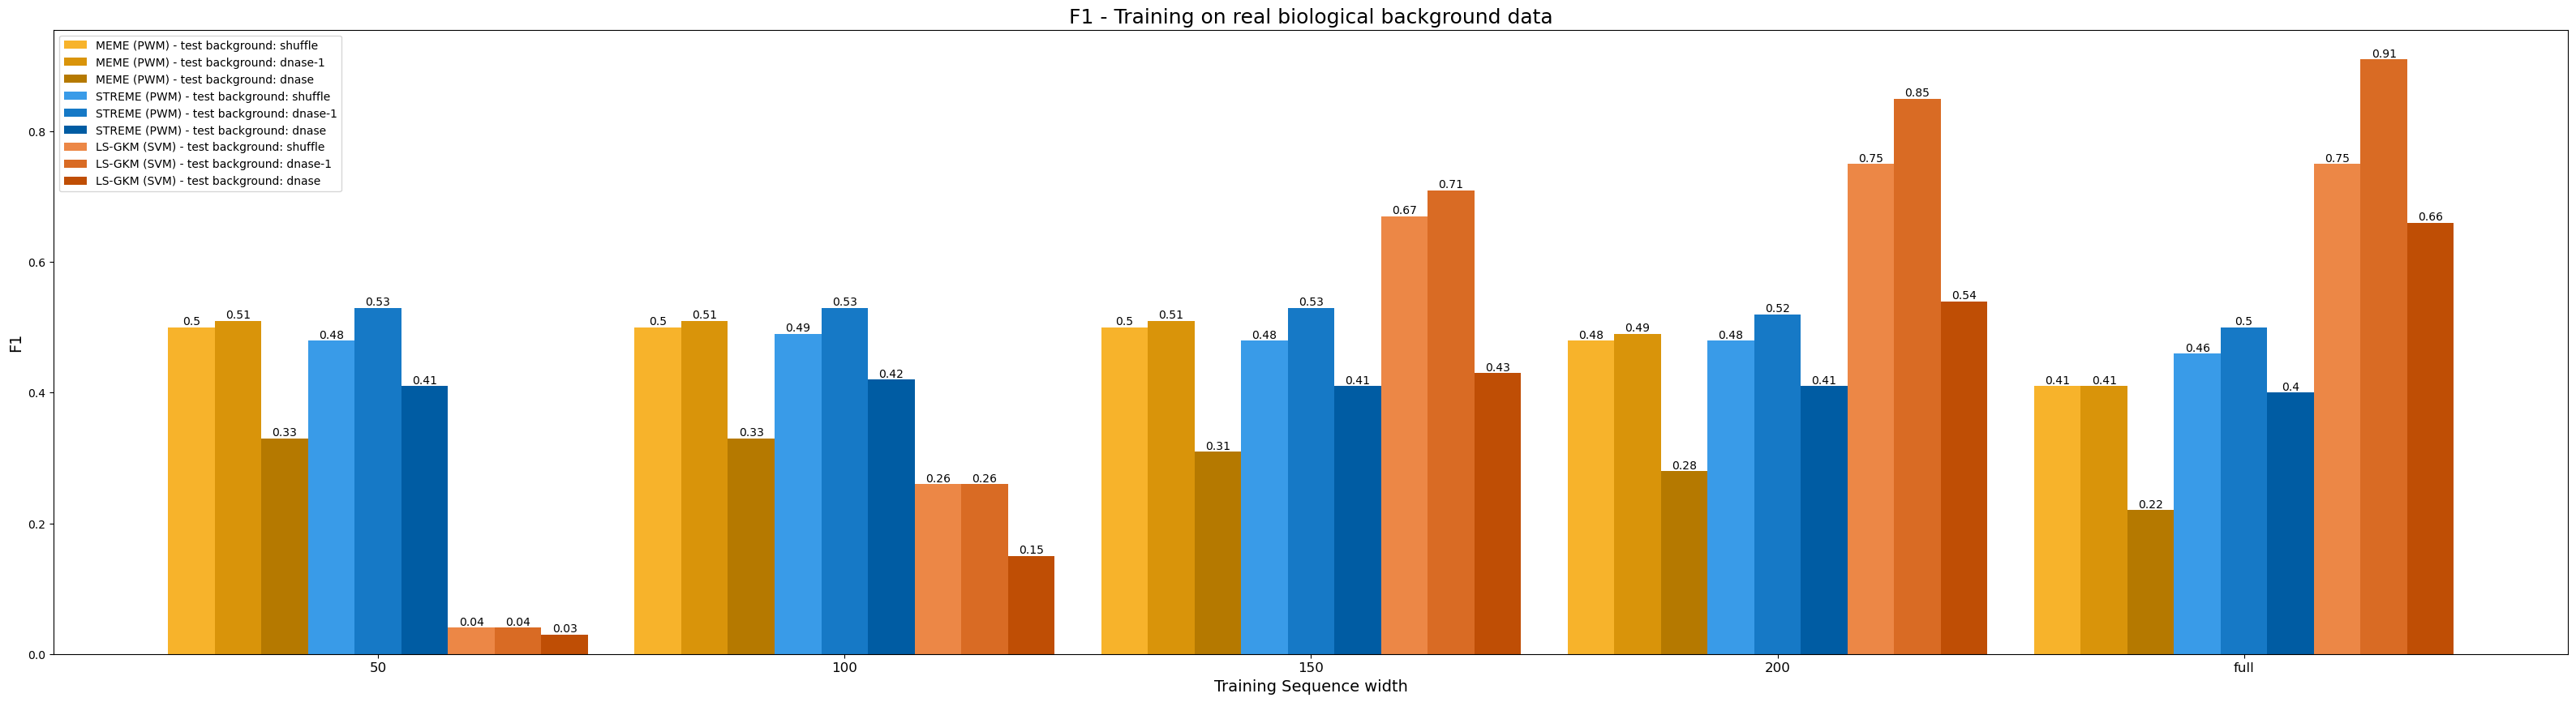

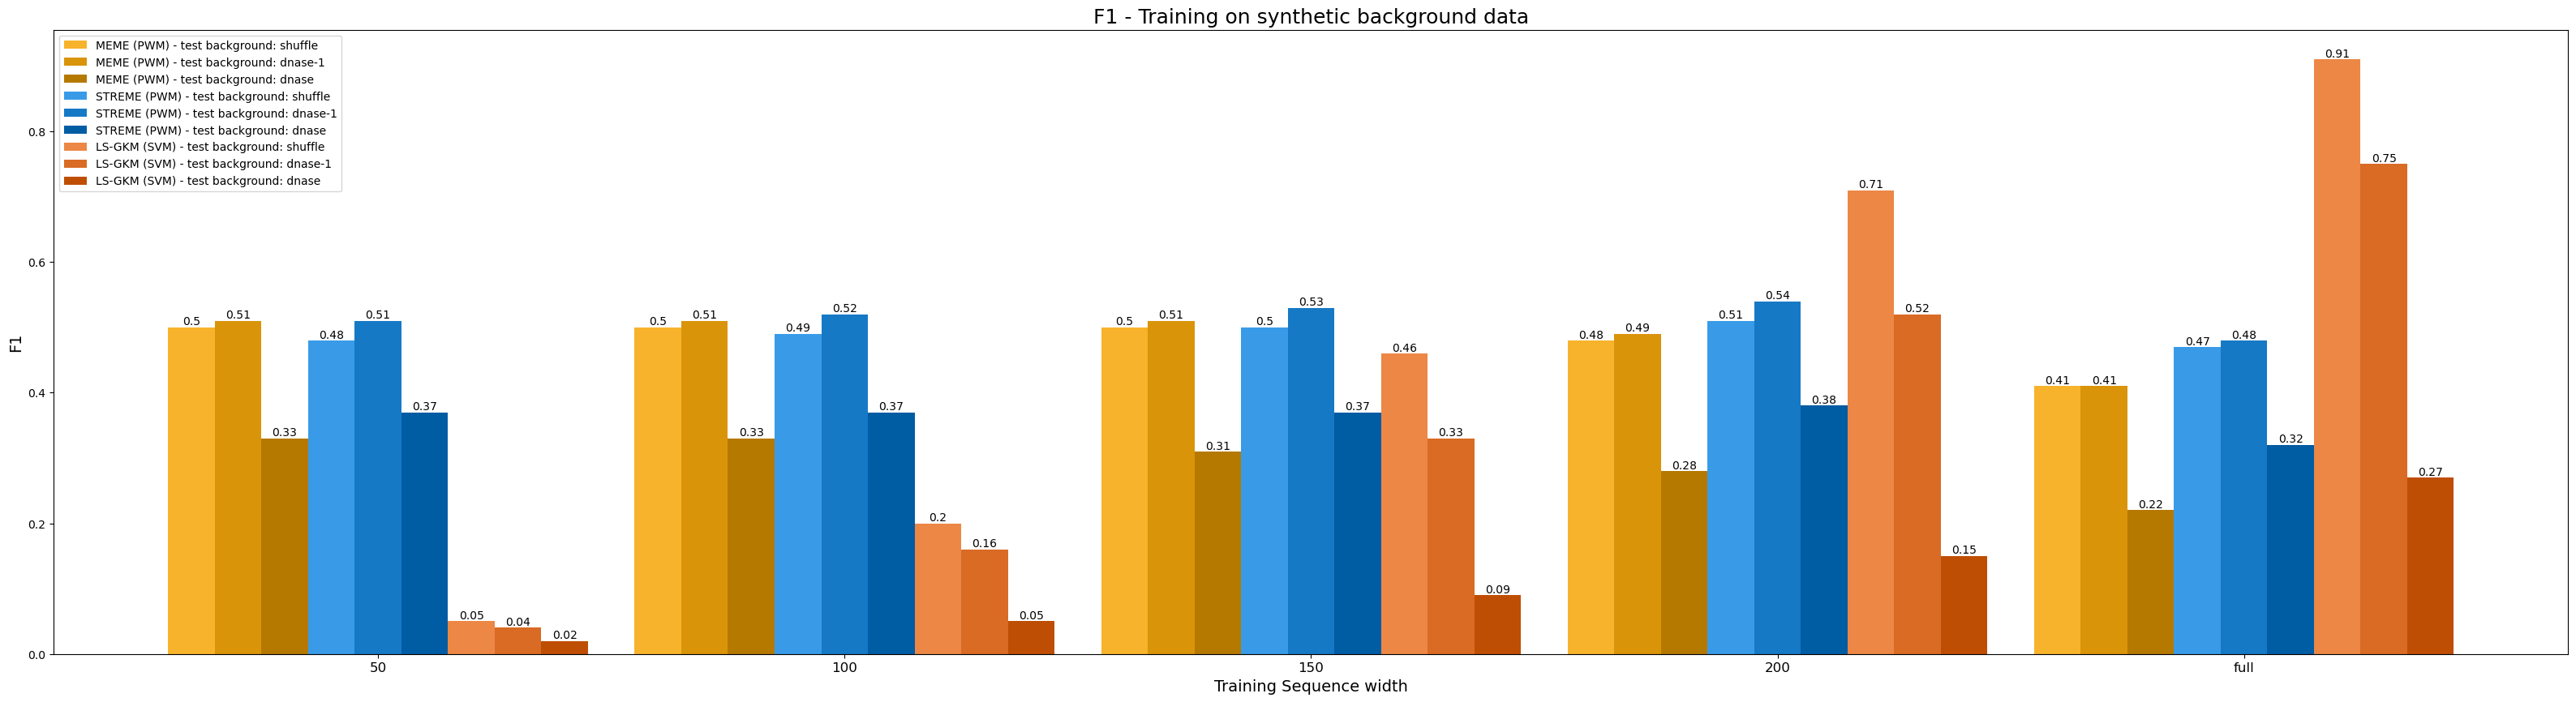

In [45]:
# F1
performance_dir = os.path.join(PERFORMANCEDIR, "sequence-width-comparison")
for bg in ["dnase", "shuffle"]:
    barplot(performance_dir, "F1", bg)

## Compare performance training models using globally optimal sequence features

In [56]:
def compute_mean(infolder, tool, metric):
    fname = os.path.join(infolder, f"summary_table_global_{tool}.tsv")
    table = pd.read_csv(fname, sep="\t")
    return np.mean(table[metric]).round(2)

def plot(data, labels, group_labels, metric):
    num_groups = len(group_labels)
    num_bars = len(data)
    x = np.arange(num_groups)  # The label locations
    width = 0.1 # The width of the bars
    colors = ["#f7b32b", "#d9940a", "#b57900", "#399be8", "#1679c6", "#005ca3", "#ec8746", "#d96b24", "#bf4e05"]  # meme, streme, ls-gkm
    f, ax = plt.subplots(figsize=(15, 10))
    for i, (values, label) in enumerate(zip(data, labels)):
        bars = ax.bar(x + i * width, values, width, label=label, color=colors[i])
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom', fontsize=10)
    ax.set_xlabel("Training Background data", size=14)
    ax.set_ylabel(metric, size=14)
    ax.set_title(f"{metric}", size=18)
    ax.set_xticks(x + width * (num_bars / 2 - 0.5))
    ax.set_xticklabels(group_labels, size=12)
    ax.legend()
    plt.show()


def barplot(infolder, metric):
    bgtrain = ["shuffle", "dnase"]
    tools = ["MEME (PWM)", "STREME (PWM)", "LS-GKM (SVM)"]
    data = [[] for _ in range(9)]
    for bg in bgtrain:
        for i, (trainbg, testbg) in enumerate([(bg, bt) for bt in BGTEST]):
            tablesdir = os.path.join(infolder, f"{trainbg}-{testbg}")
            data[0 + i].append(compute_mean(tablesdir, "meme", metric))
            data[3 + i].append(compute_mean(tablesdir, "streme", metric))
            data[6 + i].append(compute_mean(tablesdir, "svm", metric))
    labels = [f"{tool} - test background: {testbg}" for tool in tools for testbg in BGTEST]
    bgtrain_labs = ["Synthetic", "Real Biological"]
    plot(data, labels, bgtrain_labs, metric)


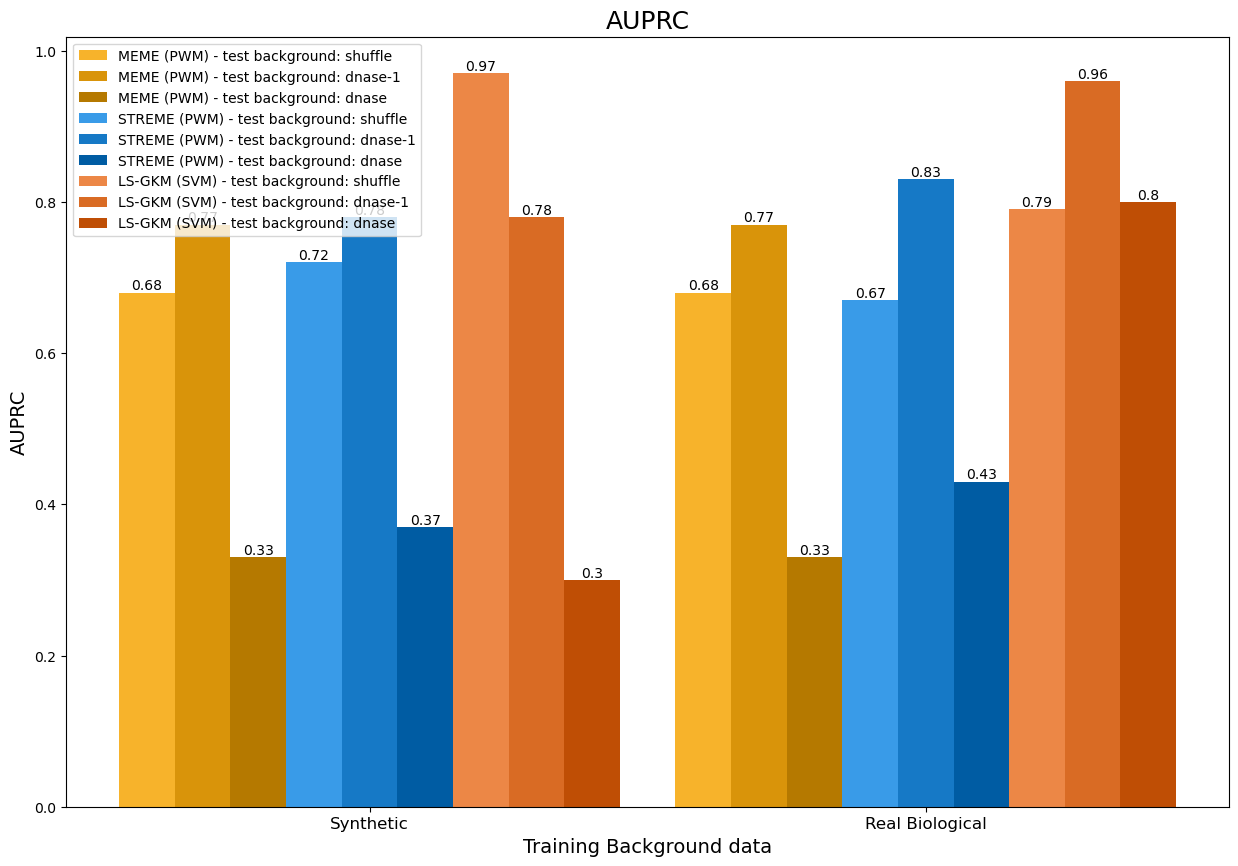

In [ ]:
# AUPRC
performance_dir = os.path.join(PERFORMANCEDIR, "optimal-global")
barplot(performance_dir, "AUPRC")

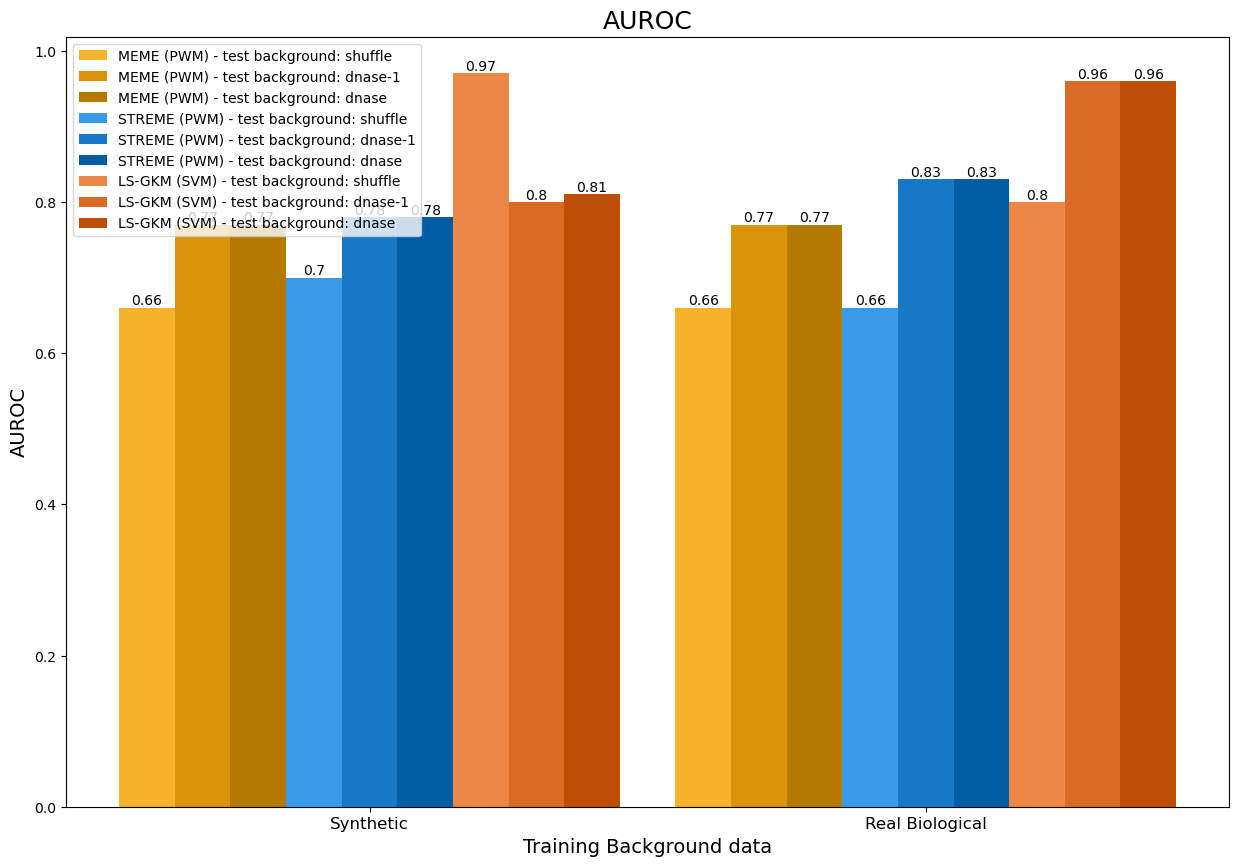

In [58]:
# AUROC
performance_dir = os.path.join(PERFORMANCEDIR, "optimal-global")
barplot(performance_dir, "AUROC")

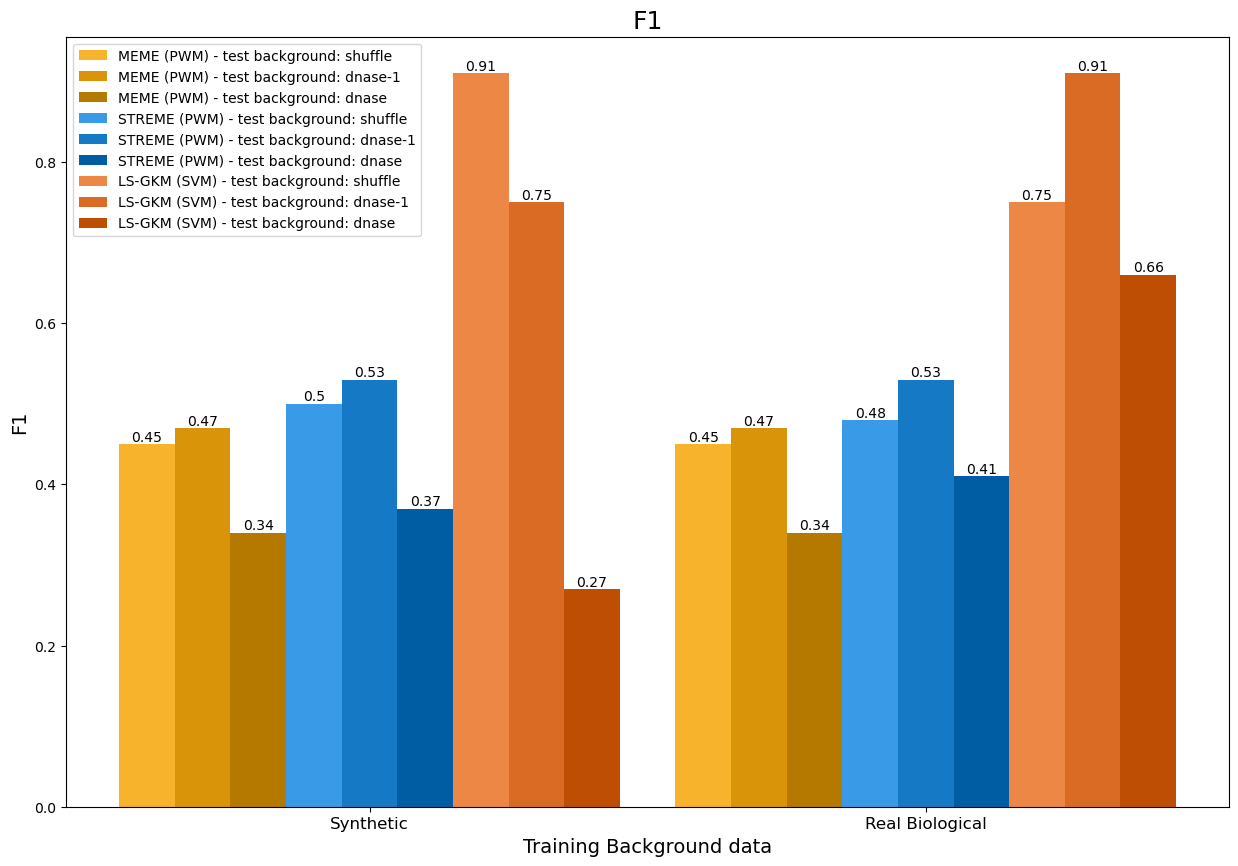

In [59]:
# F1
performance_dir = os.path.join(PERFORMANCEDIR, "optimal-global")
barplot(performance_dir, "F1")